In [3]:
#!/usr/bin/env python
import numpy as np
import random
from tqdm import tqdm
import pickle

np.set_printoptions(precision=4, suppress=True)

# ------------------------------
# Q-Learning Code Implementation
# ------------------------------
class GridworldEnv:
    def __init__(self, grid_size=(4, 4)):
        self.rows, self.cols = grid_size
        # Define special states with forced destination and reward.
        self.special_states = {
            (0, 1): {'dest': (3, 1), 'reward': 10},
            (0, 3): {'dest': (2, 3), 'reward': 5}
        }
        # Actions: 0: left, 1: up, 2: right, 3: down.
        self.actions = {
            0: (0, -1),
            1: (-1, 0),
            2: (0, 1),
            3: (1, 0)
        }
        self.action_list = [0, 1, 2, 3]
        self.intended_prob = 0.9
        self.slip_prob = 0.05  # probability for each perpendicular move

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols

    def get_perpendicular_actions(self, action):
        if action in [0, 2]:
            return [1, 3]
        elif action in [1, 3]:
            return [0, 2]
        else:
            return []

    def get_outcomes(self, state, action):
        """
        Computes all possible outcomes for a given state and action.
        Returns a list of tuples: (probability, next_state, reward)
        following the dynamics of the gridworld.
        """
        if state in self.special_states:
            forced_dest = self.special_states[state]['dest']
            reward = self.special_states[state]['reward']
            return [(1.0, forced_dest, reward)]

        outcomes = []
        intended_action = action
        base_reward = 0
        probs = [self.intended_prob, self.slip_prob, self.slip_prob]
        actions_to_consider = [intended_action] + self.get_perpendicular_actions(intended_action)
        for act, p in zip(actions_to_consider, probs):
            dr, dc = self.actions[act]
            next_state = (state[0] + dr, state[1] + dc)
            if not self.in_bounds(next_state):
                outcomes.append((p, state, -1))
            else:
                outcomes.append((p, next_state, base_reward))
        return outcomes

def compute_optimal_Q(env, gamma=0.9, tol=1e-9, max_iter=10000):
    """
    Compute the optimal Q-function Q* using value iteration.
    Returns Q* as a (rows x cols x num_actions) numpy array.
    """
    Q = np.zeros((env.rows, env.cols, len(env.action_list)))
    for it in range(max_iter):
        Q_new = np.zeros_like(Q)
        for r in range(env.rows):
            for c in range(env.cols):
                state = (r, c)
                for a in env.action_list:
                    if state in env.special_states:
                        forced_dest = env.special_states[state]['dest']
                        reward = env.special_states[state]['reward']
                        Q_new[r, c, a] = reward + gamma * np.max(Q[forced_dest[0], forced_dest[1]])
                    else:
                        probs = [env.intended_prob, env.slip_prob, env.slip_prob]
                        actions_to_consider = [a] + env.get_perpendicular_actions(a)
                        value = 0.0
                        for p, act in zip(probs, actions_to_consider):
                            dr, dc = env.actions[act]
                            next_state = (r + dr, c + dc)
                            if not env.in_bounds(next_state):
                                value += p * (-1 + gamma * np.max(Q[r, c]))
                            else:
                                value += p * (0 + gamma * np.max(Q[next_state[0], next_state[1]]))
                        Q_new[r, c, a] = value
        err = np.max(np.abs(Q_new - Q))
        Q = Q_new
        if err < tol:
            print(f"Value iteration converged in {it+1} iterations with error {err:.2e}.")
            break
    return Q

class QLearningAgent:
    def __init__(self, env, alpha_constant=0.1,alpha_diminishing=0.5, gamma=0.9):
        self.env = env
        self.alpha_constant = alpha_constant      # learning rate
        self.alpha_diminishing = alpha_diminishing 
        self.gamma = gamma      # discount factor
        #self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros((env.rows, env.cols, len(env.action_list)))

def run_q_learning(Q_star,constant_steps=5, diminishing_steps=2, alpha_constant=0.05, alpha_diminishing=0.05,
                   gamma=0.7, beta=0.65):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    error_history = []   # To record the sup-norm error after each episode

    for t in tqdm(range(constant_steps), desc="constant steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    agent.Q[r, c, a] = (1 - alpha_constant) * agent.Q[r, c, a] + alpha_constant * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
        
    partial_sum = np.zeros_like(Q_star)
    max_norm = 0.0
    
    for t in tqdm(range(diminishing_steps), desc="diminishing steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    lr = alpha_diminishing * ((t + 1) ** (-beta))
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
        error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_sum += (Q_traj - Q_star)
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
                    
    return agent, env, max_norm, error_history, Q_traj


In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def run_single_q_learning(seed, Q_star, constant_steps, diminishing_steps, alpha_constant, alpha_diminishing, gamma, beta):
    np.random.seed(seed)
    random.seed(seed)
    _, _, max_norm, error_history, Q_traj = run_q_learning(Q_star = Q_star,
        constant_steps=constant_steps,
        diminishing_steps=diminishing_steps,
        alpha_constant= alpha_constant, 
        alpha_diminishing=alpha_diminishing,
        gamma=gamma,
        beta=beta
    )
    return max_norm, error_history, Q_traj

def run_experiments_parallel(B, Q_star, constant_steps, diminishing_steps, alpha_constant, alpha_diminishing,
                             gamma, beta, n_jobs=5):
    seeds = list(range(B))
    with tqdm_joblib(tqdm(total=B, desc="Running experiments", ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning)(seed, Q_star, constant_steps, diminishing_steps,
                                            alpha_constant, alpha_diminishing, gamma, beta)
            for seed in seeds
        )
    return results


/Users/sohambonnerjee/jupyter_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
if __name__ == "__main__":
    # Experiment parameters.
    B = 500
    constant_step = 1000
    diminishing_step = 5000
    alpha_constant = 0.05
    alpha_diminishing = 0.05
    gamma = 0.1
    beta = 0.65
    ###### Compute Q^star

    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    Q_star = compute_optimal_Q(env, gamma=gamma)

    results = run_experiments_parallel(B, Q_star, constant_step, diminishing_step,
                                       alpha_constant, alpha_diminishing, gamma, beta, n_jobs=5)

    # Unzip the results into separate lists
    max_norm_list, all_error_history, final_Q_list = zip(*results)  # This gives tuples
    max_norm_list = list(max_norm_list)
    all_error_history = list(all_error_history)
    final_Q_list = list(final_Q_list)

    # Save Q_traj
    with open("max_norm_list.pkl", "wb") as f:
        pickle.dump(max_norm_list, f)
    print(f"Saved max_norm_list.pkl with {len(max_norm_list)} experiments.")
    
    with open("final_Q_list.pkl", "wb") as f:
        pickle.dump(final_Q_list, f)
    print(f"Saved final_Q_list.pkl with {len(final_Q_list)} experiments.")


    # Save error history
    with open("all_error_history.pkl", "wb") as f:
        pickle.dump(all_error_history, f)
    print(f"Saved all_error_history.pkl with {len(all_error_history)} experiments.")


Value iteration converged in 11 iterations with error 5.37e-10.


Running experiments:   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

diminishing steps: 100%|██████████████████████████████████████| 5000/5000 [00:01<00:00, 2692.18it/s]


Saved max_norm_list.pkl with 500 experiments.
Saved final_Q_list.pkl with 500 experiments.
Saved all_error_history.pkl with 500 experiments.


Value iteration converged in 11 iterations with error 5.37e-10.


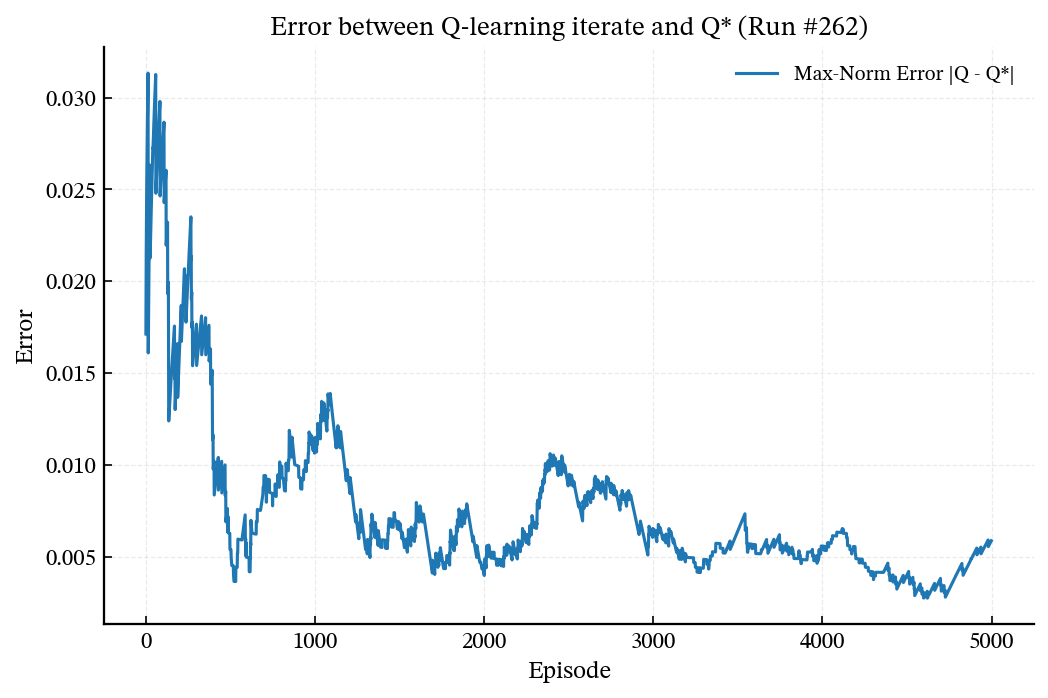

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

# Load saved data
with open("all_error_history.pkl", "rb") as f:
    all_error_history = pickle.load(f)

with open("final_Q_list.pkl", "rb") as f:
    final_Q_list = pickle.load(f)

# Load environment and optimal Q*
env = GridworldEnv()
Q_star = compute_optimal_Q(env, gamma=gamma)

# Randomly select one run
idx = random.randint(0, len(all_error_history) - 1)
error_history = all_error_history[idx]
final_Q = final_Q_list[idx]

# Plot the error curve over episodes
plt.figure(figsize=(8, 5))
plt.plot(range(len(error_history)), error_history, label='Max-Norm Error |Q - Q*|')
plt.xlabel("Episode")
plt.ylabel("Error")
plt.title(f"Error between Q-learning iterate and Q* (Run #{idx})")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Helper to print Q-values
def print_q_values(Q, title="Q-values"):
    print(title)
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            q_vals = Q[i, j]
            print(f"State ({i},{j}): {q_vals}")
        print()

# Print learned and optimal Q-values
print_q_values(final_Q, "Learned Q-values (final)")
print_q_values(Q_star, "Optimal Q* (from value iteration)")

# Print derived greedy policy
def print_policy(Q, env):
    action_names = {0: "←", 1: "↑", 2: "→", 3: "↓"}
    policy = np.full((env.rows, env.cols), " ")
    for i in range(env.rows):
        for j in range(env.cols):
            state = (i, j)
            if state in env.special_states:
                policy[i, j] = "F"  # Forced transition
            else:
                best_action = int(np.argmax(Q[i, j]))
                policy[i, j] = action_names[best_action]
    print("Derived Greedy Policy:")
    print(policy)

print_policy(final_Q, env)

Learned Q-values (final)
State (0,0): [-0.8714 -0.8247  0.8535  0.0071]
State (0,1): [10.0007 10.0007 10.0007 10.0007]
State (0,2): [ 0.8535 -0.7484  0.4031  0.0834]
State (0,3): [5.0003 5.0003 5.0003 5.0003]

State (1,0): [-0.8886  0.0292  0.0855 -0.0468]
State (1,1): [0.0602 0.9017 0.0602 0.0082]
State (1,2): [0.0855 0.0833 0.0409 0.0073]
State (1,3): [ 0.0338  0.4057 -0.8383 -0.0445]

State (2,0): [-0.8998 -0.044   0.0075 -0.0559]
State (2,1): [0.0054 0.0811 0.0055 0.0007]
State (2,2): [0.0077 0.0081 0.0007 0.0005]
State (2,3): [ 0.0026 -0.0107 -0.8986 -0.0514]

State (3,0): [-0.9522 -0.0516 -0.0466 -0.9572]
State (3,1): [-0.0508  0.0071 -0.0466 -0.9004]
State (3,2): [-0.0464  0.0006 -0.0514 -0.9009]
State (3,3): [-0.0473 -0.0471 -0.9524 -0.9524]

Optimal Q* (from value iteration)
State (0,0): [-0.8684 -0.8188  0.8548  0.012 ]
State (0,1): [10.0007 10.0007 10.0007 10.0007]
State (0,2): [ 0.8548 -0.7481  0.4047  0.0827]
State (0,3): [5.0002 5.0002 5.0002 5.0002]

State (1,0): [-0.888

In [8]:
###### Compute Q^star

env = GridworldEnv()
agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
Q_star = compute_optimal_Q(env, gamma=gamma)

Value iteration converged in 11 iterations with error 5.37e-10.


In [9]:
with open("max_norm_list.pkl", "rb") as f:
    max_norm_list = pickle.load(f)

# now performing bootstrap

In [10]:
def state_action_index(state, action, env):
    """
    Map a (state, action) pair to a unique index.
    Assumes state is a tuple (row, col) and env.action_list gives the ordering of actions.
    """
    r, c = state
    return (r * env.cols + c) * len(env.action_list) + action


def simulate_Bhat_samples(env, Q_star, gamma=0.9, T=10):
    """
    Simulate T independent samples of the Bellman operator \hat{B}(Q_star)
    for every state–action pair, taking into account the special states.
    
    For each state–action pair (s,a):
      - If s is special, then the outcome is forced:
            sample = r(s,a) + gamma * max_{a'} Q_star(forced_dest, a')
        where forced_dest and r(s,a) are given by env.special_states.
      - Otherwise, sample a branch (with probabilities [0.9, 0.05, 0.05]) using 
            outcomes = env.get_outcomes(s, a)
        and compute:
            sample = r + gamma * max_{a'} Q_star(s_next, a')
    
    Returns:
      samples: a (T x D) numpy array, where D = |S|*|A|.
    """
    env = GridworldEnv()
    D = env.rows * env.cols * len(env.action_list)
    samples = np.zeros((T, D))
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    
    for t in tqdm(range(T), desc="sampling bellman noise", ncols=100, position=0):
        sample_vec = np.zeros(D)
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    idx = state_action_index(s, a, env)
                    if s in env.special_states:
                        # Special state: use forced destination and reward.
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        sample_vec[idx] = reward + gamma * np.max(Q_star[forced_dest[0], forced_dest[1]])
                    else:
                        # Non-special state: sample a branch.
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        sample_vec[idx] = r_val + gamma * np.max(Q_star[s_next[0], s_next[1]])
                        
        samples[t, :] = sample_vec
    return samples

B_vec = simulate_Bhat_samples(env, Q_star, gamma=gamma, T=10000)
#B_vec = simulate_Bhat_samples(env, agent.Q, T=10000)
Z_vec=B_vec-np.mean(B_vec, axis=0)
Gamma_est=np.cov(Z_vec, rowvar=False)
np.linalg.eigvals(Gamma_est)

sampling bellman noise: 100%|███████████████████████████████| 10000/10000 [00:03<00:00, 2968.93it/s]


array([ 2.1712+0.j,  0.8743+0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j, -0.    +0.j, -0.    +0.j,  0.    +0.j,  0.    +0.j,
       -0.    +0.j, -0.    +0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j, -0.    +0.j,
       -0.    +0.j, -0.    +0.j, -0.    +0.j, -0.    -0.j,  0.    +0.j,
        0.    +0.j, -0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,
       -0.    +0.j, -0.    +0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j,  0.    +0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j, -0.    +0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j, -0.    +0.j,
       -0.    +0.j,  0.    +0.j, -0.    +0.j,  0.    +0.j, -0.    +0.j,
        0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,
        0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j])

In [11]:
def compute_P(env):
    """
    Compute the transition matrix 𝒫 ∈ ℝ^(D x |S|) where D = |S|*|A|.
    For each state–action pair (s, a), the row in 𝒫 gives the probability distribution
    over next states.
    """
    S = env.rows * env.cols
    A = len(env.action_list)
    D = S * A
    P = np.zeros((D, S))
    for s in range(S):
        r_idx = s // env.cols
        c_idx = s % env.cols
        state = (r_idx, c_idx)
        for a in env.action_list:
            row = s * A + a
            outcomes = env.get_outcomes(state, a)
            for (p, s_next, _) in outcomes:
                s_next_index = s_next[0] * env.cols + s_next[1]
                P[row, s_next_index] += p
    return P

def compute_Pi(pi):
    """
    Given a policy matrix pi ∈ ℝ^(|S| x |A|) (one row per state),
    construct the projection matrix Π^π ∈ ℝ^(|S| x D) where D = |S|*|A|.
    Each row s of Π^π is a one-hot vector corresponding to the greedy action.
    """
    S, A = pi.shape
    D = S * A
    Pi = np.zeros((S, D))
    for s in range(S):
        start = s * A
        end = (s + 1) * A
        Pi[s, start:end] = pi[s]
    return Pi


def compute_H_and_Sigma (Q_star, env, Gamma_star):
    S = env.rows * env.cols
    A = len(env.action_list)
    D = S * A
    I = np.eye(D)
    
    # Compute the transition matrix (assumed known).
    P = compute_P(env)  # shape (D, S)
    
    Q_star = Q_star.reshape((env.rows, env.cols, A))
    
    # Build policy matrix: shape (S, A).
    pi = np.zeros((S, A))
    for s in range(S):
        r_idx = s // env.cols
        c_idx = s % env.cols
        best_a = np.argmax(Q_star[r_idx, c_idx])
        pi[s, best_a] = 1.0
    # Compute Π^π.
    Pi = compute_Pi(pi)  # shape (S, D)
    # Compute H^{π} = 𝒫 Π^π. (𝒫: D x S, Π^π: S x D, so H: D x D)
    H = P @ Pi

    # Build A = I - gamma * H
    A = I - gamma * H
    M     = np.linalg.solve(A, Gamma_star.T)
    # step 2: solve A · Σ = M^T          →  Σ = A^{-1} (Γ^* A^{-T})
    Sigma = np.linalg.solve(A, M.T)
    return H, Sigma


H_star, Sigma_star = compute_H_and_Sigma(Q_star, env, Gamma_est)

#Sigma_cholesky = np.linalg.cholesky(Sigma_star) 
#Gamma_cholesky = np.linalg.cholesky(Gamma_est)

def simulate_Y(H, Q_star , env, Gamma_star, alpha_constant=0.4, alpha_diminishing=0.5, beta=0.8, gamma=0.9, constant_steps=500, diminishing_steps=100):
    """
    Simulate the process:
         Y_t = (I - eta_t (I - gamma * H^{π_{t-1}})) Y_{t-1} + eta_t * Z_t,
    where H^{π_{t-1}} = 𝒫 Π^{π_{t-1}}, and the greedy policy π_{t-1} is computed
    from Q_traj[t-1].
    
    Inputs:
      - Q_traj: list of Q-learning iterates (each Q is an array of shape (rows, cols, |A|)),
                corresponding to the diminishing phase.
      - env: the gridworld environment.
      - Gamma_star: the (D x D) noise covariance matrix.
      - alpha, beta: parameters for the step-size, eta_t = alpha * t^(-beta).
      - gamma: discount factor.
    
    Returns:
      - Y: the final Y vector (D-dimensional),
      - Y_traj: list of Y vectors at each update.
    """
    S = env.rows * env.cols
    A = len(env.action_list)
    D = S * A
    I = np.eye(D)
    Y = np.zeros(D)   # Initialize Y_0 = 0.
    Y_traj = Y.copy()
    Y_history = []
    
    for t in tqdm(range(constant_steps), desc="bootstrap:constant steps", ncols=100, position=0):
        eta = alpha_constant 
        # Get the policy π_{t-1} from Q_traj[t-1] by taking the greedy action at each state.
        
        # Sample Z_t ~ N(0, Gamma_star)
        Z_t = np.random.multivariate_normal(np.zeros(D), Gamma_star)
        # Update Y.
        Y = (I - eta * (I - gamma * H)) @ Y_traj + eta * Z_t
        Y_traj=Y.copy()
        Y_history.append(np.max(np.abs(Y)))
        
    #Q_traj= Q_traj[(constant_steps+1):(constant_steps+diminishing_steps)]
    partial_sum = np.zeros_like(Y_traj)
    max_norm = 0.0
      
    for t in tqdm(range(diminishing_steps), desc="bootstrap:diminishing steps", ncols=100, position=0):
        eta = alpha_diminishing * (t+1)**(-beta)
        # Sample Z_t ~ N(0, Gamma_star)
        Z_t = np.random.multivariate_normal(np.zeros(D), Gamma_star)
        # Update Y.
        Y = (I - eta * (I - gamma * H)) @ Y_traj + eta * Z_t
        Y_traj=Y.copy()
        partial_sum += Y_traj
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
        Y_history.append(np.max(np.abs(Y_traj)))
        
        
    return  Y_traj, Y_history, max_norm

# Example usage:
# Assume that Q_traj is a list of Q arrays from your diminishing-phase Q-learning,
# env is your GridworldEnv instance, and Gamma_star is the noise covariance matrix.
# For example:
# Y_final, Y_traj = simulate_Y_from_Qtraj(Q_traj, env, Gamma_star, alpha=0.4, beta=0.8, gamma=0.9)


#Y_sim, Y_sim_traj, Y_history = simulate_Y(Q_traj, env, Gamma_est, constant_steps=0, diminishing_steps=10000)



In [12]:
import random
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def simulate_Y_from_single_Q(H, Q_star, env, Gamma_star, constant_steps=0, diminishing_steps=10000,
                             alpha_constant=0.4, alpha_diminishing=0.5, beta=0.8, gamma=0.9):
    """
    Run simulate_Y on a fixed Q_traj (randomness comes only from noise).
    """
    return simulate_Y(H, Q_star, env, Gamma_star,
                      alpha_constant=alpha_constant,alpha_diminishing=alpha_diminishing, beta=beta, gamma=gamma,
                      constant_steps=constant_steps,
                      diminishing_steps=diminishing_steps)

def run_Y_simulations_on_one_Q(H, Q_star, env, Gamma_star, B=100,
                               constant_steps=0, diminishing_steps=10000,
                               alpha_constant=0.4, alpha_diminishing=0.5, beta=0.8, gamma=0.9,
                               n_jobs=4):
    """
    Run simulate_Y B times using the last Q_traj in all_Q_traj.
    Each run uses different noise due to sampling from N(0, Gamma_star).
    """
    #Q_traj_sample = all_Q_traj[-1]  # Use the last Q_traj

    with tqdm_joblib(tqdm(total=B, desc="Simulating Y on last Q_traj", ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(simulate_Y_from_single_Q)(
                H,
                Q_star, env, Gamma_star,
                constant_steps=constant_steps,
                diminishing_steps=diminishing_steps,
                alpha_constant=alpha_constant,alpha_diminishing=alpha_diminishing, beta=beta, gamma=gamma
            )
            for _ in range(B)
        )
    return results  # List of (Y_final, Y_traj, Y_history)


In [13]:
Y_results = run_Y_simulations_on_one_Q(
    H_star,
    Q_star,
    env,
    Gamma_star=Gamma_est,
    B=B,
    constant_steps=constant_step,
    diminishing_steps=diminishing_step,
    alpha_constant=alpha_constant,
    alpha_diminishing=alpha_diminishing,
    beta=beta,
    gamma=gamma,
    n_jobs=5
)

# Unpack for plotting or analysis
Y_trajs, Y_histories, max_norms_Y = zip(*Y_results)



Simulating Y on last Q_traj:   0%|                                          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

bootstrap:diminishing steps: 100%|████████████████████████████| 5000/5000 [00:04<00:00, 1173.24it/s]


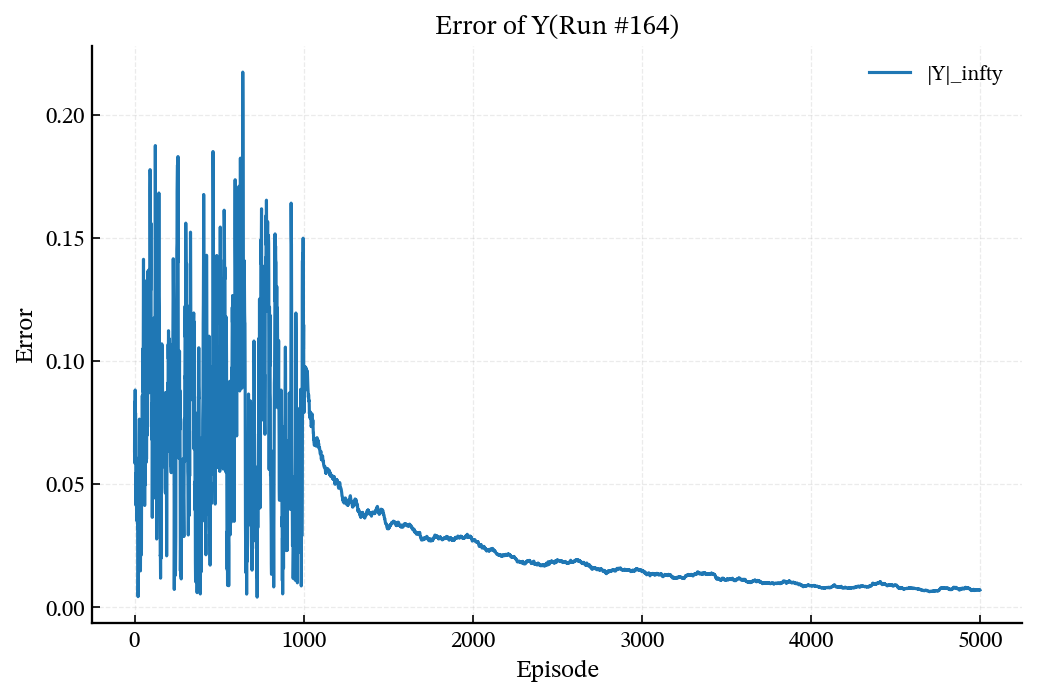

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

# Load saved data
with open("Y_histories.pkl", "wb") as f:
    pickle.dump(Y_histories, f)

with open("Y_histories.pkl", "rb") as f:
    Y_histories = pickle.load(f)

# Load environment and optimal Q*
#env = GridworldEnv()
#Q_star = compute_optimal_Q(env, gamma=0.9)

# Randomly select one run
idx = random.randint(0, len(Y_histories) - 1)
Y_error_history = Y_histories[idx]
Y_error_history = Y_error_history[(0):(diminishing_step)]
#Q_traj = all_Q_traj[idx]
#final_Q = Q_traj[-1]

# Plot the error curve over episodes
plt.figure(figsize=(8, 5))
plt.plot(range(len(Y_error_history)), Y_error_history, label='|Y|_infty')
plt.xlabel("Episode")
plt.ylabel("Error")
plt.title(f"Error of Y(Run #{idx})")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
with open("max_norms_Y.pkl", "wb") as f:
    pickle.dump(max_norms_Y, f)

with open("max_norms_Y.pkl", "rb") as f:
    max_norms_Y = pickle.load(f)
    
#max_norms_Y

In [17]:
def simulate_Br(Sigma, env, gamma=0.9, diminishing_steps=100):
    """
    Simulate the process:
         Y_t = (I - eta_t (I - gamma * H^{π_{t-1}})) Y_{t-1} + eta_t * Z_t,
    where H^{π_{t-1}} = 𝒫 Π^{π_{t-1}}, and the greedy policy π_{t-1} is computed
    from Q_traj[t-1].
    
    Inputs:
      - Q_traj: list of Q-learning iterates (each Q is an array of shape (rows, cols, |A|)),
                corresponding to the diminishing phase.
      - env: the gridworld environment.
      - Gamma_star: the (D x D) noise covariance matrix.
      - alpha, beta: parameters for the step-size, eta_t = alpha * t^(-beta).
      - gamma: discount factor.
    
    Returns:
      - Y: the final Y vector (D-dimensional),
      - Y_traj: list of Y vectors at each update.
    """
    S = env.rows * env.cols
    A = len(env.action_list)
    D = S * A
    
    Y = np.zeros(D)   # Initialize Y_0 = 0.
    Br_history = []
    
    partial_sum = np.zeros_like(Y)
    max_norm = 0.0
      
    for t in tqdm(range(diminishing_steps), desc="bootstrap:diminishing steps", ncols=100, position=0):
        # Sample Z_t ~ N(0, Gamma_star)
        Z = np.random.multivariate_normal(np.zeros(D), Sigma)
        partial_sum += Z
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
        Br_history.append(np.max(np.abs(Z)))
        
        
    return  Br_history, max_norm


def run_Br_simulations(Sigma , env, gamma, diminishing_steps, B, n_jobs):
    """
    Run simulate_Y B times using the last Q_traj in all_Q_traj.
    Each run uses different noise due to sampling from N(0, Gamma_star).
    """
    #Q_traj_sample = all_Q_traj[-1]  # Use the last Q_traj

    with tqdm_joblib(tqdm(total=B, desc="Simulating Y on last Q_traj", ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(simulate_Br)(
                Sigma, env, 
                gamma=gamma, 
                diminishing_steps=diminishing_steps
            )
            for _ in range(B)
        )
    return results  # List of (Y_final, Y_traj, Y_history)


Br_results = run_Br_simulations(
    Sigma_star,
    env,
    gamma=gamma,
    diminishing_steps=constant_step+ diminishing_step,
    B=B,
    n_jobs=5
)

Br_histories, max_norms_Br = zip(*Br_results)


Simulating Y on last Q_traj:   0%|                                          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

bootstrap:diminishing steps: 100%|████████████████████████████| 6000/6000 [00:05<00:00, 1035.18it/s]


In [18]:
with open("max_norms_Br.pkl", "wb") as f:
    pickle.dump(max_norms_Br, f)

with open("max_norms_Br.pkl", "rb") as f:
    max_norms_Br = pickle.load(f)
    
#max_norms_Y

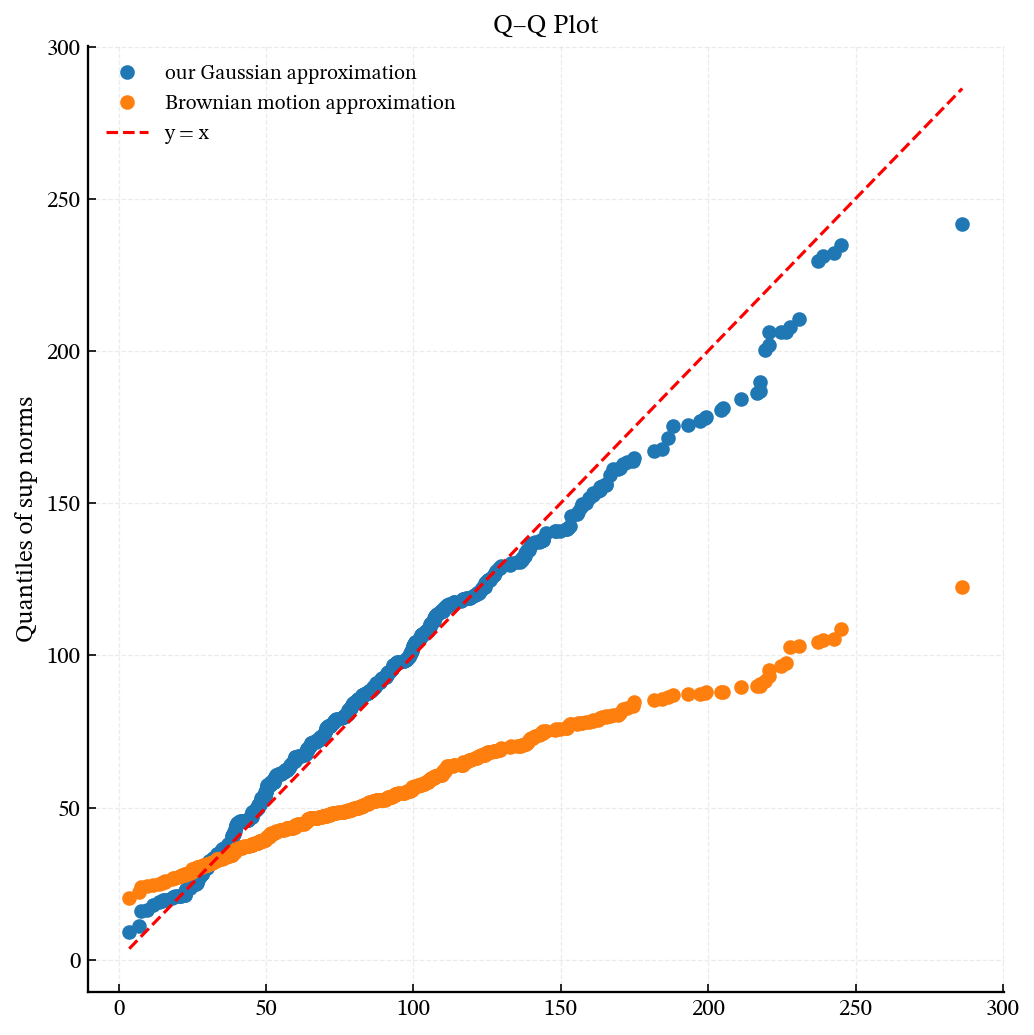

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# your existing arrays
supnorm_Y  = np.array(max_norms_Y)
supnorm_Q  = np.array(max_norm_list)
supnorm_Br = np.array(max_norms_Br)

# sort for quantiles
supnorm_Q_sorted  = np.sort(supnorm_Q)
supnorm_Y_sorted  = np.sort(supnorm_Y)
supnorm_Br_sorted = np.sort(supnorm_Br)

# set up figure
plt.figure(figsize=(7, 7))

# Q vs Y
plt.plot(supnorm_Q_sorted,
         supnorm_Y_sorted,
         marker='o',
         linestyle='',
         label='our Gaussian approximation')

# Q vs Br
plt.plot(supnorm_Q_sorted,
         supnorm_Br_sorted,
         marker='o',
         linestyle='',
         label='Brownian motion approximation')

# 45° reference line
minval = min(supnorm_Q_sorted.min(),
             supnorm_Y_sorted.min(),
             supnorm_Br_sorted.min())
maxval = max(supnorm_Q_sorted.max(),
             supnorm_Y_sorted.max(),
             supnorm_Br_sorted.max())

plt.plot([minval, maxval],
         [minval, maxval],
         'r--',
         label='y = x')

# labels, legend, etc.
plt.xlabel("")
plt.ylabel("Quantiles of sup norms")
plt.title("Q–Q Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


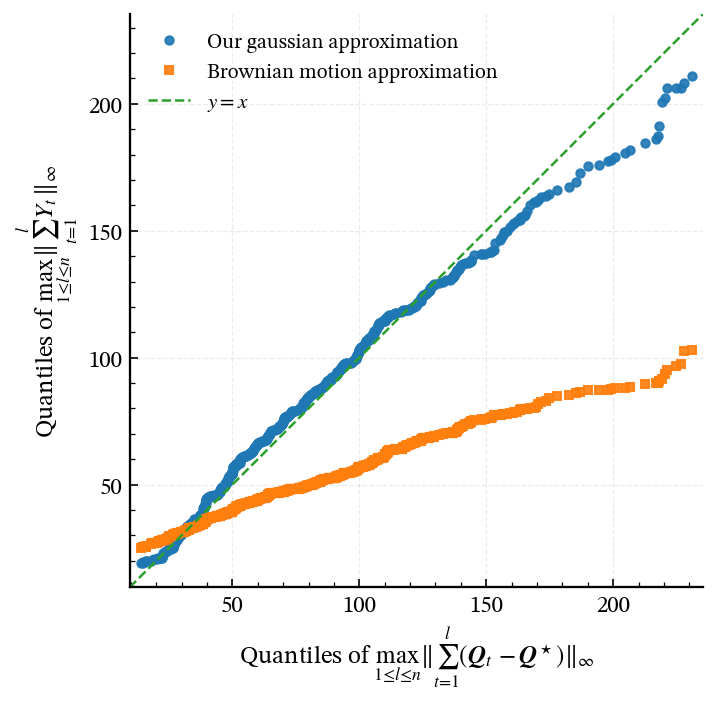

In [21]:
# -------------
# NeurIPS-style Q–Q plot (sup-norms): Q vs Y and Q vs Brownian
# -------------

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# ---- style ----
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times New Roman", "DejaVu Serif", "STIXGeneral", "CMU Serif"],
    "mathtext.fontset": "stix",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1.1,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.autolayout": False,
})

def qq_match(a, b, qmin=0.01, qmax=0.99):
    """
    Quantile-match two arrays (handles unequal lengths & NaNs).
    Returns matched quantiles (qa, qb).
    """
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    n = min(len(a), len(b))
    qs = np.linspace(qmin, qmax, n)
    return np.quantile(a, qs), np.quantile(b, qs)

# --- your arrays ---
supnorm_Y  = np.array(max_norms_Y)
supnorm_Q  = np.array(max_norm_list)
supnorm_Br = np.array(max_norms_Br)

# quantile-matched pairs
xq, yq   = qq_match(supnorm_Q, supnorm_Y)
_,  brq  = qq_match(supnorm_Q, supnorm_Br)

# bounds
mn = float(min(xq.min(), yq.min(), brq.min()))
mx = float(max(xq.max(), yq.max(), brq.max()))
pad = 0.02 * (mx - mn if mx > mn else 1.0)
lo, hi = mn - pad, mx + pad

# -------------
# figure
# -------------
fig = plt.figure(figsize=(7.5, 4.8))
ax = plt.gca()

# scatter Q vs Y
ax.plot(xq, yq, 'o', ms=4.0, alpha=0.9, label="Our gaussian approximation")

# scatter Q vs Br
ax.plot(xq, brq, 's', ms=4.0, alpha=0.9, label="Brownian motion approximation")

# 45° line
ax.plot([lo, hi], [lo, hi], '--', linewidth=1.2, label=r"$y=x$")

# labels
ax.set_xlabel(r"Quantiles of $\max_{1 \leq l \leq n}\|\sum_{t=1}^l (\boldsymbol{Q}_t - \boldsymbol{Q}^\star)\|_\infty$")
ax.set_ylabel(r"Quantiles of $\max_{1 \leq l \leq n}\|\sum_{t=1}^l Y_t\|_\infty$")

# axis settings
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_aspect('equal', adjustable='box')
ax.minorticks_on()

# legend
ax.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

# -------------
# save
# -------------
fig.savefig("qq_supnorm_Q_vs_Y_and_Br.png",  bbox_inches="tight")
#fig.savefig("qq_supnorm_Q_vs_Y_and_Br.pdf",  bbox_inches="tight")
#fig.savefig("qq_supnorm_Q_vs_Y_and_Br.svg",  bbox_inches="tight")
